In [65]:
from model import *

import sys
#!{sys.executable} -m pip install [arg]

import time
import random
import numpy as np
import networkx as nx

from itertools import product

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

# 1) Construct network

In [3]:
def build_graph(n=100, m=3, p=0.5):
    G = nx.powerlaw_cluster_graph(n=n, m=m, p=p) 
    assert nx.is_connected(G)
    return G


def get_adjacency(G):
    return dict((n, set(nbrdict.keys())) for n, nbrdict in G.adjacency())

# 2) Define groups

In [4]:
def get_communities(G):
    return list(nx.community.label_propagation_communities(G))
 

def get_node_community_map(communities):
    node_community_map = {}
    for i,c in enumerate(communities):
        for node in c:
            node_community_map[node] = i
    return node_community_map


def get_community_membership(adjacency, node_community_map):
    membership = {i:set() for i in node_community_map}
    for i, neighbours in adjacency.items():
        for n in neighbours:
            membership[i].add(node_community_map[n])
        membership[i].add(node_community_map[i])
    membership = {k:list(v) for k,v in membership.items()}
    return membership

# 3) Generate projects

In [486]:
def generate_gambles(N):
    """
    Generate N gambles with 2 outcomes.
    """
    probs1   = np.random.uniform(0.2, 0.8, N)
    probs2   = 1 - probs1
    
    outcomes1 = np.random.uniform(0.9, 0.95, N)
    outcomes2 = np.random.uniform(2.0, 2.5, N)
        
    gambles = []
    for i in range(N):
        gambles.append({
            "outcomes" : [outcomes1[i],outcomes2[i]],
            "probs"    : [probs1[i],probs2[i]]
        })
    return gambles


def get_gamble_return(P):
    return np.random.choice(P["outcomes"], p=P["probs"])

# 4) Maximize expected utility

In [487]:
def utility(x, w, project_allocations, project_returns, risk, safe_return, A, gamma):
    """
    Compute expected utility.
    Args:
        x : consumption proportion
        w : wealth level of agent
        project_allocations : allocation of savings to risky projects
        project_returns : expected project return
        risk : parameter controlling level of risk-aversion
        safe_return : safe return amount
        A : utility function parameter
        gamma : utility function parameter
    Returns:
        utility
    """
    # utility from consumption
    consumption_utility = U(w*x, A=A, gamma=gamma)
    
    # expected utility from projects
    project_utility = V((1-risk)*(1-x)*w*safe_return + sum(risk*(1-x)*w*project_allocations*project_returns))
    
    return -(consumption_utility + project_utility)

In [488]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, variance)

# 5) Simulation

In [544]:
gambles = generate_gambles(N=2)
gamble_averages  = []
gamble_variances = []
for g in gambles:
    avg, var = weighted_avg_and_std(g["outcomes"], g["probs"])
    gamble_averages.append(avg)
    gamble_variances.append(var)

mu = np.array(gamble_averages) 
cov = np.diag(gamble_variances)
cov_inv = np.linalg.inv(cov)
ones = np.ones((len(gamble_averages),))
val = cov_inv @ ((mu - 1.1) * ones)
allocation = val / (ones @ val)

print(f"Gamble 1 = {gamble_averages[0]:.3f} ± {gamble_variances[0]:.3f}")
print(f"Gamble 2 = {gamble_averages[1]:.3f} ± {gamble_variances[1]:.3f}")

print(f"Allocation over gambles : {allocation}")

Gamble 1 = 1.624 ± 0.440
Gamble 2 = 1.697 ± 0.470
Allocation over gambles : [0.48371392 0.51628608]


In [583]:
w = 0.1
risk = 0.8

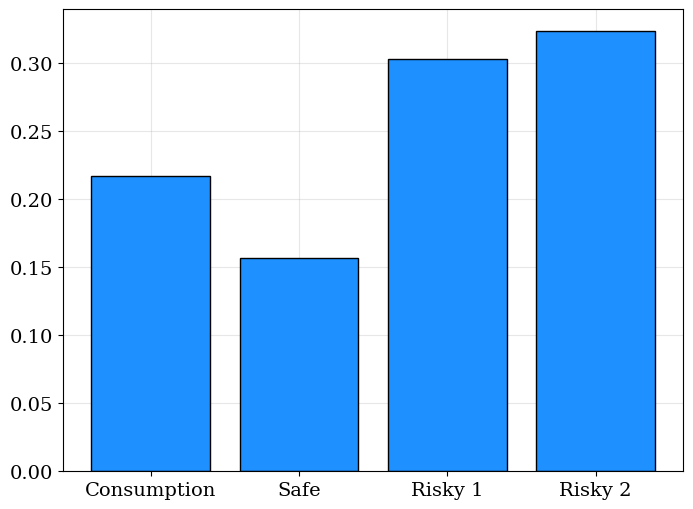

In [584]:
c = minimize(utility, x0=0.5, bounds=[(0.0, 1.0),], method='SLSQP',
             args=(w, allocation, gamble_averages, alpha, 1.2, 2.1, 1.1)).x[0]
plt.bar(np.arange(4), [c, (1-c)*(1-risk), (1-c)*risk*allocation[0], (1-c)*risk*allocation[1]],
        color="dodgerblue", edgecolor="k")

plt.xticks(np.arange(4), ["Consumption", "Safe", "Risky 1", "Risky 2"])
plt.show()

### Chat-GPT attempt:

In [646]:
# Define the expected return vector and covariance matrix of the N risky assets
mu = np.array([0.10, 0.15, 0.12])
cov = np.array([[0.04, 0.0, 0.0],
                [0.0, 0.09, 0.0],
                [0.0, 0.0, 0.06]])

# Define the expected return and risk-free rate of the risk-free asset
rf = 0.08

mu = np.concatenate([mu, [rf]])

# Define the risk aversion parameter
gamma = 2

# Append a row and a column of zeros to the covariance matrix to account for the risk-free asset
cov = np.vstack((cov, np.zeros((1, 3))))
cov = np.hstack((cov, np.zeros((4, 1))))

# Define the objective function to minimize
def objective(W):
    expected_return = np.dot(mu, W)
    variance = np.dot(np.dot(W, cov), W)
    return -(expected_return - gamma*variance)

# Define the constraint that the sum of the weights in the weight vector equals 1
def constraint(W):
    return np.sum(W) - 1.0

# Define the initial guess for the weight vector
W0 = np.ones(mu.shape[0]) / (mu.shape[0])

# Define the bounds for the weight vector
bounds = [(0.0, 1.0) for i in range(mu.shape[0])]

# Define the constraint as a dictionary
cons = {'type': 'eq', 'fun': constraint}

# Solve the optimization problem
result = minimize(objective, W0, method='SLSQP', bounds=bounds, constraints=cons)

# Extract the optimal weight vector
W_opt = result.x

# Print the optimal weight vector and the expected return and variance of the portfolio
print('Optimal weight vector:', W_opt)
print('Expected return of portfolio:', np.dot(mu, W_opt))
print('Variance of portfolio:', np.dot(np.dot(W_opt, cov), W_opt))

Optimal weight vector: [0.12514556 0.19486019 0.1666258  0.51336845]
Expected return of portfolio: 0.10280815657167842
Variance of portfolio: 0.005709650345369046


### My attempt (advantage: no scipy optimization step)

In [650]:
mu = np.array([0.10, 0.15, 0.12])
cov = np.diag([0.04, 0.09, 0.06])

cov_inv = np.linalg.inv(cov)
ones = np.ones((len(mu),))
val = cov_inv @ ((mu - 0.08) * ones)
allocation = val / (ones @ val)

In [653]:
allocation

array([0.25714286, 0.4       , 0.34285714])

In [654]:
def simulation(NUM_AGENTS=500, STEPS=1, SAFE_RETURN=1.1, DEFAULT_A=1.2, DEFAULT_GAMMA=2.1,
               PROJECT_COST=3.0, W0=0.8, W1=1.2, R0=0.3, R1=0.7, graph=None):
    """
    Runs ABM model.
    Args:
        NUM_AGENTS    : number of agents
        STEPS         : number of steps
        SAFE_RETURN   : safe return coefficient (> 1.0)
        DEFAULT_A     : parameter used in utility functions
        DEFAULT_GAMMA : parameter used in utility functions
        PROJECT_COST  : minimum cost for project to be undertaken
        W0            : left bound for uniform random wealth initialization
        W1            : right bound for uniform random wealth initialization
        R0            : left bound for uniform random risk initialization
        R1            : right bound for uniform random risk initialization
    Returns:
        WEALTH      : (STEPS, NUM_AGENTS) array containing wealth levels of agents at each iteration
        communities : dict from community ID to list of members
    """
    
    # construct graph and adjacency matrix
    G = graph or build_graph(n=NUM_AGENTS, m=2)
    adjacency = get_adjacency(G)
    
    # extract communities
    communities = get_communities(G)
    print(f"{len(communities)} communities.")
    
    # get community membership of nodes
    node_community_map = get_node_community_map(communities)
    community_membership = get_community_membership(adjacency, node_community_map)
    communities = {c:[] for c in range(len(communities))}
    for i, comms in community_membership.items():
        for c in comms:
            communities[c].append(i)

    # global attributes
    GAMBLES = generate_gambles(len(communities))
    
    gamble_averages  = []
    gamble_variances = []
    for g in GAMBLES:
        avg, var = weighted_avg_and_std(g["outcomes"], g["probs"])
        gamble_averages.append(avg)
        gamble_variances.append(var)
            
    # agent attributes
    WEALTH = np.random.uniform(W0, W1, (STEPS+1, NUM_AGENTS))
    RISK   = np.random.uniform(R0, R1, NUM_AGENTS)

    C = np.zeros((NUM_AGENTS))
    ALLOCATION = []
    
    # compute optimal portfolios for agents
    for i in range(NUM_AGENTS):
        agent_gamble_averages  = [gamble_averages[k] for k in community_membership[i]]
        agent_gamble_variances = [gamble_variances[k] for k in community_membership[i]]
        mu = np.array(agent_gamble_averages) 
        cov = np.diag(agent_gamble_variances)
        cov_inv = np.linalg.inv(cov)
        ones = np.ones((len(agent_gamble_averages),))
        val = cov_inv @ ((mu - SAFE_RETURN) * ones)
        val = val / (ones @ val)
        ALLOCATION.append(val)

        
    # metrics
    # TODO...
    
    
    # simulation
    for step in tqdm(range(STEPS)):

        project_contributions = np.zeros((len(GAMBLES)))

        # all agents perform optimization step and we sum up project contributions
        for i in range(NUM_AGENTS):
            
            C[i] = minimize(utility, x0=0.5, bounds=[(0.0, 1.0),], method='SLSQP',
                            args=(WEALTH[step][i], ALLOCATION[i],
                                  [gamble_averages[k] for k in community_membership[i]], 
                                  RISK[i], DEFAULT_A, DEFAULT_GAMMA, SAFE_RETURN)).x[0]
                        
            for j,k in enumerate(community_membership[i]):
                project_contributions[k] += np.sum(ALLOCATION[i][j]*WEALTH[step][i]*RISK[i]*(1-C[i]))
            
        # run projects
        risky_returns = np.zeros((len(GAMBLES)))
        for idx, P in enumerate(GAMBLES):
            if project_contributions[idx] >= PROJECT_COST:
                risky_returns[idx] = get_gamble_return(P)
    
        for i in range(NUM_AGENTS):
            
            # new wealth = old wealth - consumption - risky investment + risky return + safe return
            I = 1-C[i]
            S = 1-RISK[i]
            agent_risky_return = np.array([risky_returns[k] for k in community_membership[i]])
            WEALTH[step+1][i]  = WEALTH[step][i] - \
                                 WEALTH[step][i]*C[i] + \
                                 sum(WEALTH[step][i]*I*RISK[i]*ALLOCATION[i]*(agent_risky_return-1)) + \
                                 WEALTH[step][i]*S*SAFE_RETURN*I

    return WEALTH, communities

In [655]:
def count_crossover_points(W, communities=None):
    """
    Count number of crossover points at agent or community level.
    Args:
        W           : (STEPS, NUM_AGENTS) array
        communities : dict from community ID to list of members (community level if this is provided)
    Returns:
        number of crossover points.
    """
    # communities is specified, so count crossover points at community-level
    if communities:
        crossover_points = {c:0 for c in range(len(communities))}
        for c, agent_list in communities.items():
            trajectory = np.mean(W[:,agent_list], axis=1)
            for i in range(len(trajectory)-2):
                if (trajectory[i+1] - trajectory[i] > 0 and trajectory[i+2] - trajectory[i+1] < 0) or \
                   (trajectory[i+1] - trajectory[i] < 0 and trajectory[i+2] - trajectory[i+1] > 0):
                        crossover_points[c] += 1

    # otherwise count at agent level
    else:
        num_agents = W.shape[1]
        crossover_points = {a:0 for a in range(num_agents)}
        for a in range(num_agents):
            trajectory = W[:,a]
            for i in range(len(trajectory)-2):
                if (trajectory[i+1] - trajectory[i] > 0 and trajectory[i+2] - trajectory[i+1] < 0) or \
                   (trajectory[i+1] - trajectory[i] < 0 and trajectory[i+2] - trajectory[i+1] > 0):
                        crossover_points[a] += 1
                    
    return crossover_points

In [656]:
W, communities = simulation(NUM_AGENTS=500, STEPS=20, PROJECT_COST=1.0)

86 communities.


  0%|          | 0/20 [00:00<?, ?it/s]/Users/charlesdupont/Desktop/poverty-trap/model.py:21: RuntimeWarning: divide by zero encountered in power
  return x**(1-gamma) / (1-gamma)
  5%|▌         | 1/20 [00:00<00:13,  1.42it/s]/Users/charlesdupont/Desktop/poverty-trap/model.py:14: RuntimeWarning: divide by zero encountered in power
  return A*x**(1-gamma) / (1-gamma)
100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


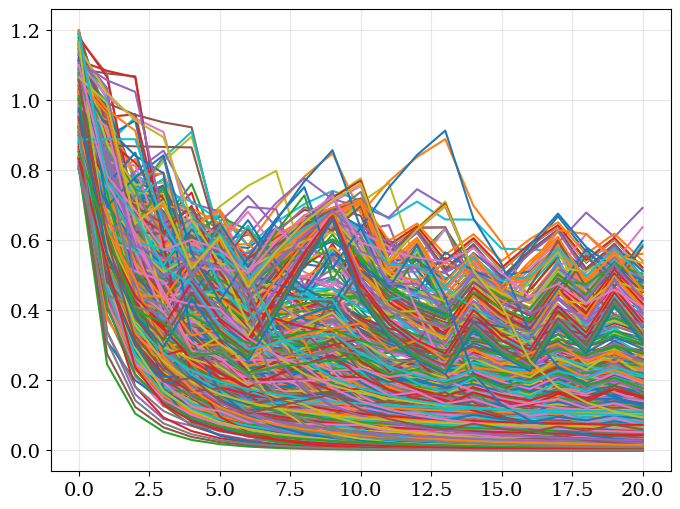

In [657]:
for i in range(W.shape[1]):
    plt.plot(W[:,i])

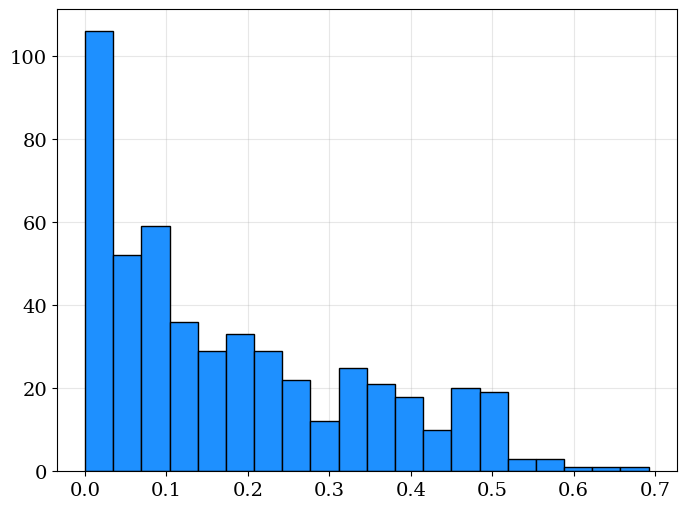

In [667]:
plt.hist(W[20], color="dodgerblue", edgecolor="k", bins=20)
plt.show()

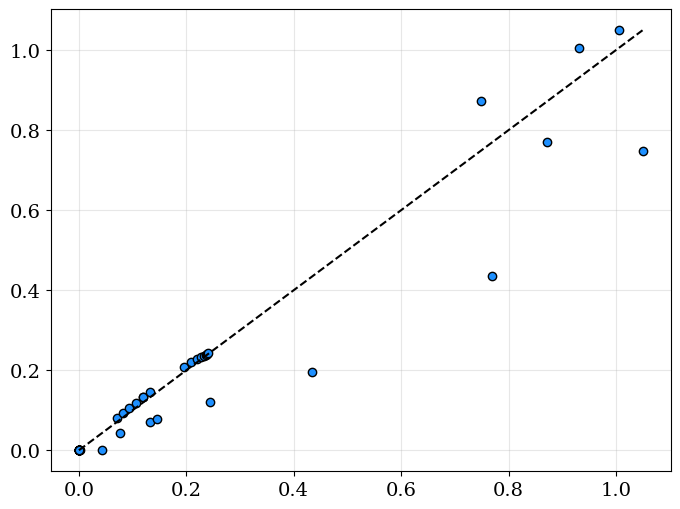

In [23]:
i = 7

x=[]
y=[]
for k in range(len(W)-1):
    x.append(W[k][i])
    y.append(W[k+1][i])
    
plt.scatter(x,y, color="dodgerblue", edgecolor="k")
plt.plot(np.linspace(min(x), max(x), 100), np.linspace(min(x), max(x), 100), color="k", linestyle="dashed")
plt.show()